In [ ]:
import math
class Scalar():
      
      def __init__(self,data,children=(),_op="",label="",grad=0.0):
          self.data = data
          self.children =children
          self._op=_op
          self.label = label
          self.grad=grad
          self._backward = lambda: None
      def __repr__(self):
         return f"Scalar(data={self.data},children={self.children},op={self._op},label={self.label})"
      def __add__(self,other):
         
            other  = other if isinstance(other,Scalar) else Scalar(other)
            out =  Scalar(self.data+other.data,children=(self,other),_op="+")
            def _backward():
                self.grad += 1.0 * out.grad
                other.grad += 1.0 * out.grad
            out._backward = _backward
            return out
      def __radd__(self, other): # other * self
            return self + other

      def __sub__(self,other):
         
              other  = other if isinstance(other,Scalar) else Scalar(other)     
              out =  Scalar(self.data-other.data,children=(self,other),_op="-")
              def _backward():
                self.grad += 1.0 * out.grad
                other.grad += -1.0 * out.grad
              out._backward = _backward
              return out
      def __rsub__(self, other): # other * self
            return self - other
         
      def __mul__(self,other):
          
              other  = other if isinstance(other,Scalar) else Scalar(other)
              out =  Scalar(data=self.data*other.data,children=(self,other),_op="*")
              
              def _backward():
                self.grad += other.data * out.grad
                other.grad += self.data * out.grad
              out._backward = _backward
              return out
      def __rmul__(self, other): # other * self
            return self * other
          
      def __truediv__(self,other):
              other  = other if isinstance(other,Scalar) else Scalar(other)
              out =  Scalar(data=self.data/other.data,children=(self,other),_op="/")
              def _backward():
                self.grad += (1 / other.data) * out.grad
                other.grad += (-self.data / (other.data ** 2)) * out.grad
              out._backward = _backward
              return out
      def __rtruediv__(self, other): # other * self
            return self / other
      
      def pow(self,k):
           if not isinstance(k,(float,int)):
             raise Exception("k must be float or integer not",type(k))
           out = Scalar(self.data**k,children=(self,),_op="pow")
           def _backward():
                self.grad += (k*self.data**(k-1)) *out.grad
           out._backward = _backward
           return out
          
      def sin(self):
          out =  Scalar(data=math.sin(self.data),children=(self,),_op="sin")
          def _backward():
                self.grad += math.cos(self.data)*out.grad
          out._backward = _backward
          return out
      def cos(self):
          out =  Scalar(data=math.cos(self.data),children=(self,),_op="cos")
          
          def _backward():
                self.grad += -math.sin(self.data)*out.grad
          out._backward = _backward
          return out
      def exp(self):
          out =  Scalar(data=math.exp(self.data),children=(self,),_op="exp")
          def _backward():
                self.grad += out.data*out.grad
          out._backward = _backward
          return out
      def tanh(self):
          
          result = (math.exp(2*self.data)-1)/(math.exp(2*self.data)+1)
          out =  Scalar(data=result,children=(self,),_op="tanh")
          def _backward():
                self.grad += (1-out.data**2)*out.grad
          out._backward = _backward
          return out
      
      def sigmoid(self):
          out =  Scalar(data=1/(1+math.exp(-self.data)),children=(self,),_op="sigmoid")
          def _backward():
                self.grad += out.data*(1-out.data)*out.grad
          out._backward = _backward
          return out
      def relu(self):
           
           out  =  Scalar(data=max(0,self.data),children=(self,),_op="relu")
           def _backend():
                self.grad += (1.0 if self.data > 0 else 0)*out.grad
           out._backward = _backend
           return out

      def backward(self):
    
            topo = []
            visited = set()
            def build_topo(v):
                if v not in visited:
                    visited.add(v)
                    for child in v.children:
                        build_topo(child)
                    topo.append(v)
            build_topo(self)
            
            self.grad = 1.0
            for node in reversed(topo):
                node._backward()


          

In [15]:
import os
os.environ["PATH"] += os.pathsep + r"C:\Program Files\Graphviz\bin"

In [16]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.children:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [19]:

a = Scalar(0.2);a.label="a"
b = Scalar(3);b.label="b"
c= a*b;c.label="c"
out = c.sigmoid();out.label="out"

out.backward()

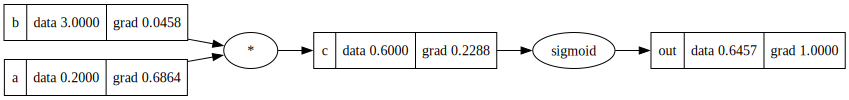

In [20]:
draw_dot(out)